# Prevendo Customer Churn em Operadoras de Telecom

## O que é Customer Churn?
Customer Churn (ou Rotatividade de Clientes, em uma tradução livre)
refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento
comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a
rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de
fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da
receita. Portanto, é muito importante prever os usuários que provavelmente
abandonarão o relacionamento comercial e os fatores que afetam as decisões do
cliente.

## Dataset
Os datasets de treino e de teste estão no repositório. O cabeçalho do dataset é uma descrição do tipo de informação em cada coluna.

### 1. Importando bibliotecas

In [1]:
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler, PCA, StringIndexer
from pyspark.sql.types import FloatType
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import  classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 500)

### 2. Criando Session

In [3]:
spSession = SparkSession.builder.master("local").appName("SparkChurn").getOrCreate()

### 3. Carregando dados

In [4]:
dataset_train = spSession.read.load("./dados/projeto4_telecom_treino.csv",
                                  format = "csv",
                                  sep = ",",
                                  inferSchema = "true",
                                  header = "true")
dataset_test = spSession.read.load("./dados/projeto4_telecom_teste.csv",
                                  format = "csv",
                                  sep = ",",
                                  inferSchema = "true",
                                  header = "true")

### 4. Concatenando os dados

In [5]:
print("Dataset Treino\nQuantidade de linhas: {}\nQuantidade de colunas: {}".format(dataset_train.count(), len(dataset_train.columns)))

Dataset Treino
Quantidade de linhas: 3333
Quantidade de colunas: 21


In [6]:
print("Dataset Teste\nQuantidade de linhas: {}\nQuantidade de colunas: {}".format(dataset_test.count(), len(dataset_test.columns)))

Dataset Teste
Quantidade de linhas: 1667
Quantidade de colunas: 21


In [7]:
dataset = dataset_train.unionAll(dataset_test)

In [8]:
print("Dataset\nQuantidade de linhas: {}\nQuantidade de colunas: {}".format(dataset.count(), len(dataset.columns)))

Dataset
Quantidade de linhas: 5000
Quantidade de colunas: 21


### 5. Overview

In [9]:
dataset.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = t

In [10]:
dataset.toPandas().head()

,_c0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


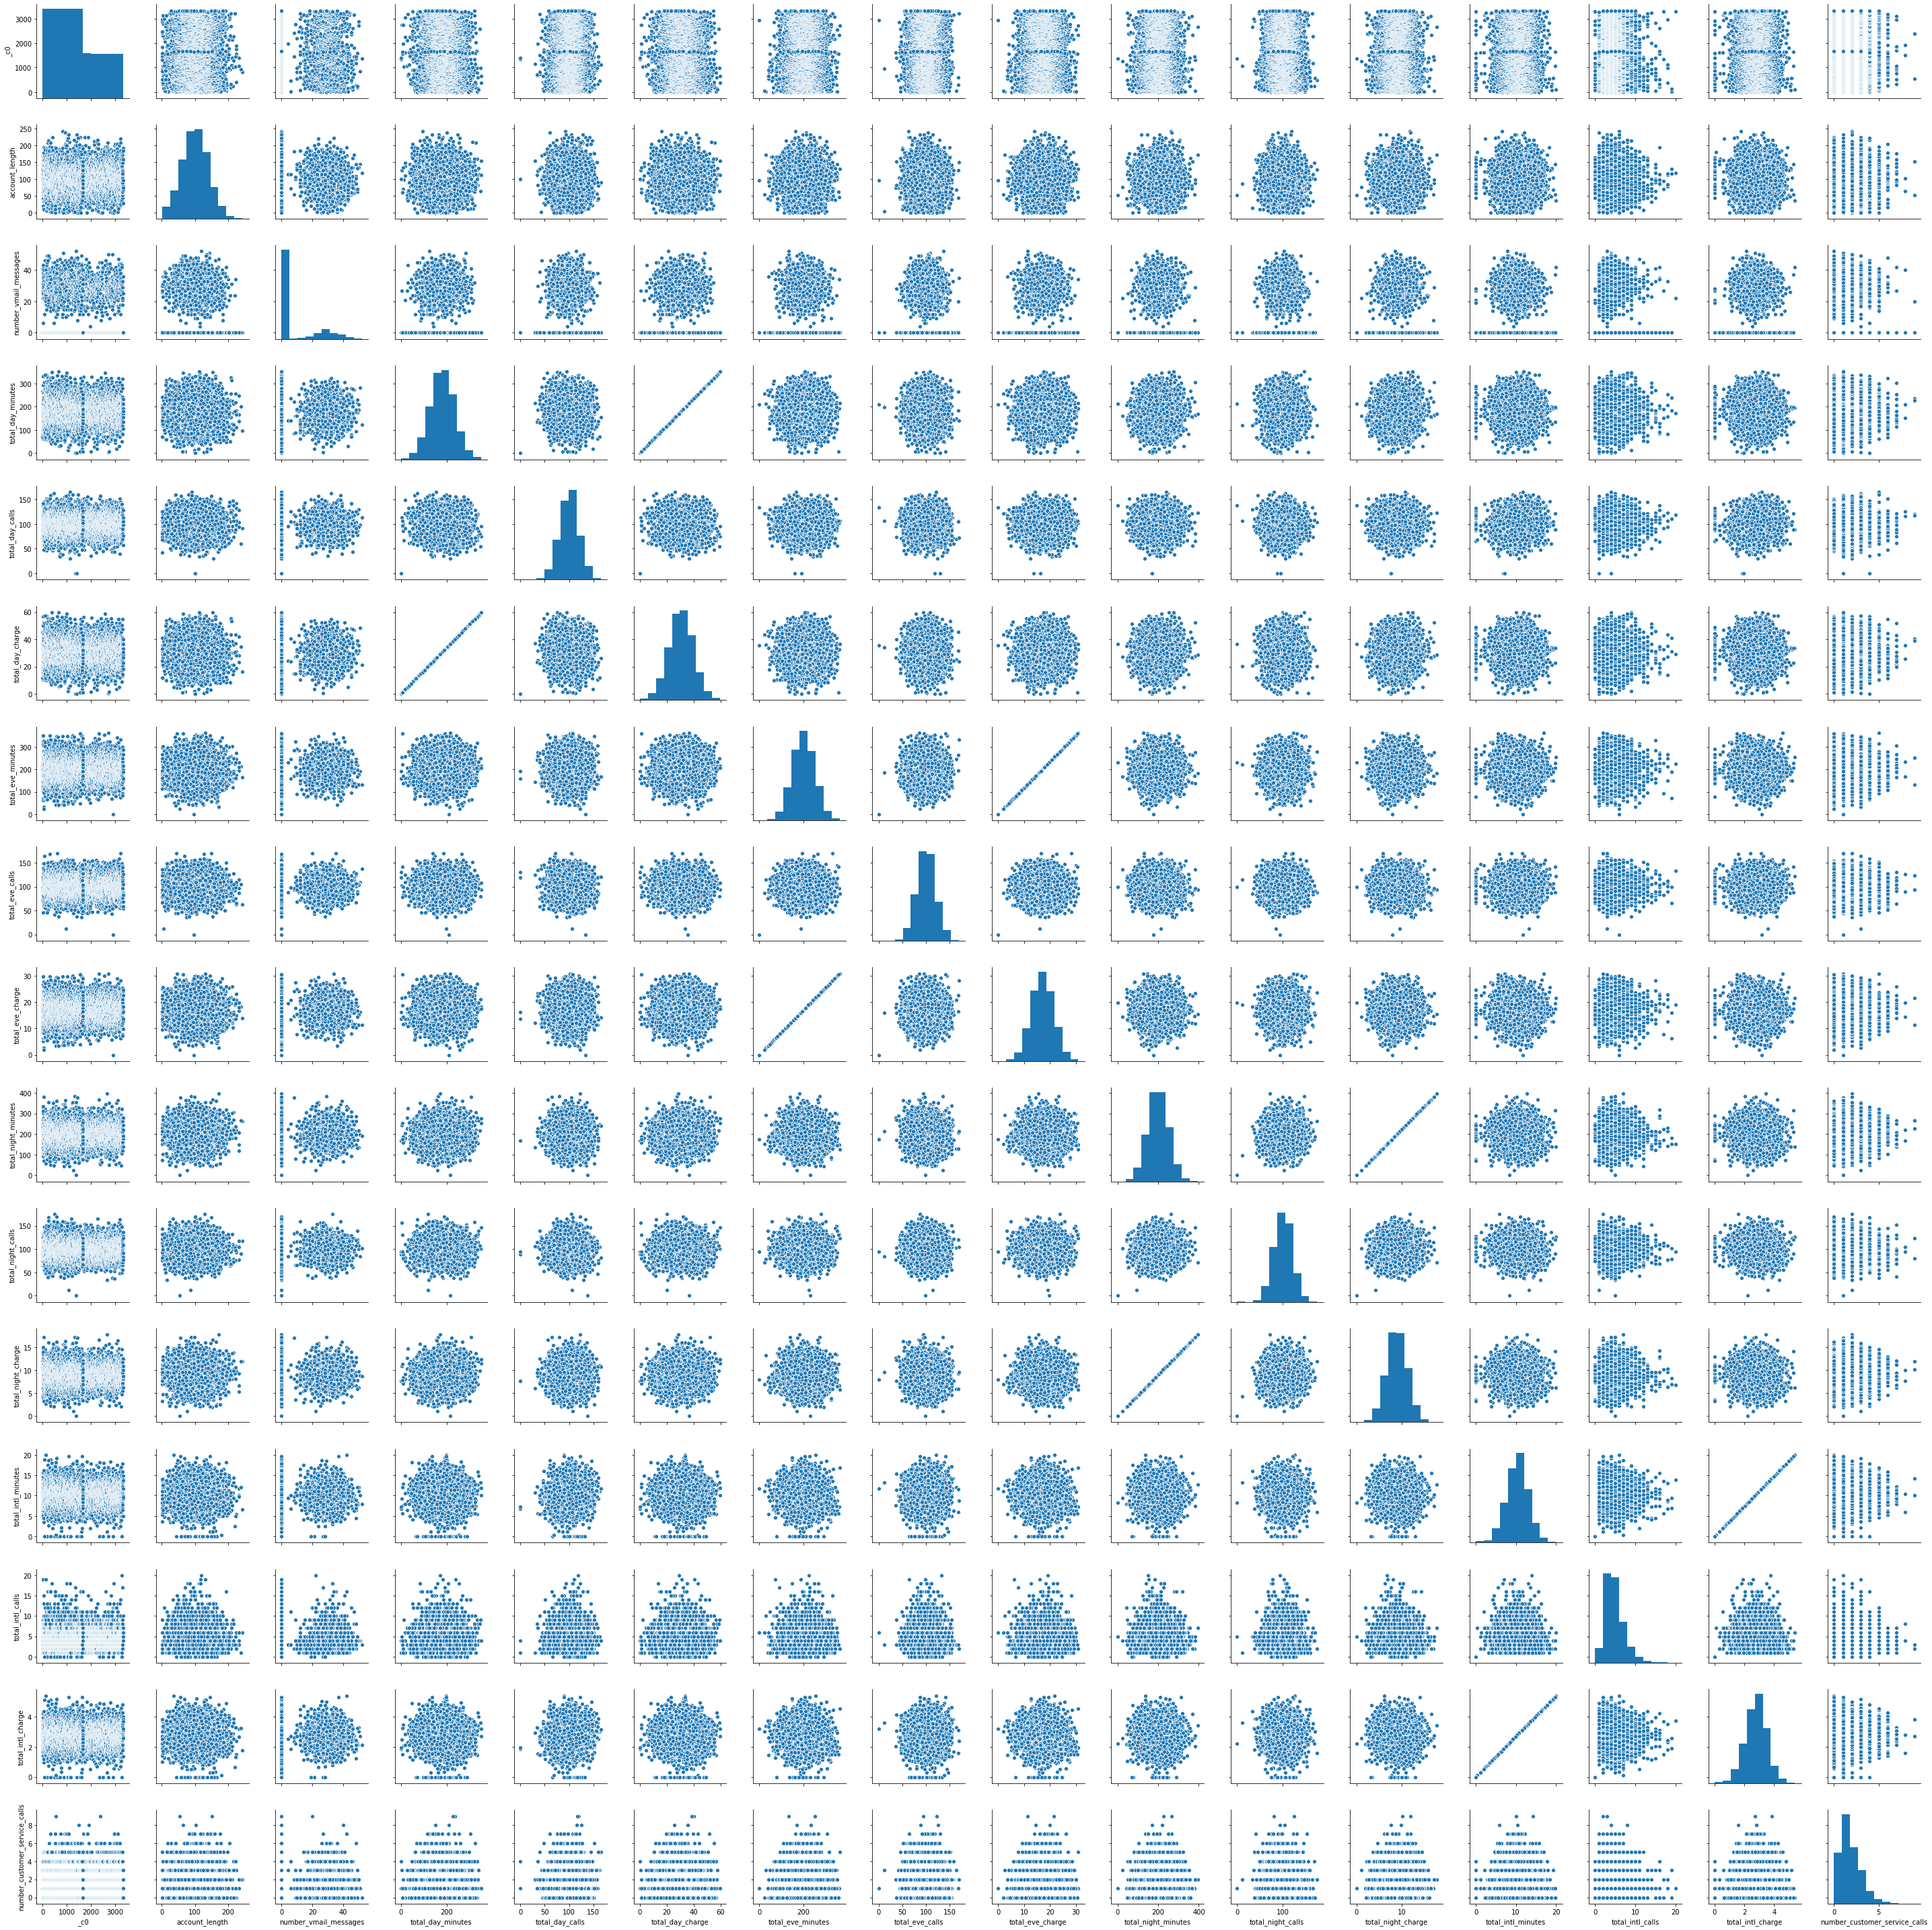

In [11]:
sns.pairplot(dataset.toPandas())

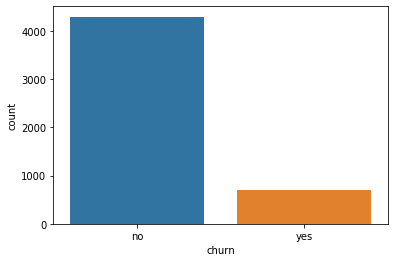

In [12]:
datasetPandas = dataset.toPandas()
sns.countplot(datasetPandas['churn'])

**Análise**:
- Dataset desbalanceado;


In [13]:
dataset.toPandas().describe()

,_c0,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1389.277800,100.25860,7.755200,180.288900,100.029400,30.649668,200.636560,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400
std,921.242753,39.69456,13.546393,53.894699,19.831197,9.162069,50.551309,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363
min,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,625.750000,73.00000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,1250.500000,100.00000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,2083.250000,127.00000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,3333.000000,243.00000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [14]:
# Removendo index
dataset = dataset.drop('_c0')

### 6. Transformando variáveis categoricas em variáveis numéricas

#### 6.1 Quais são as variáveis categóricas?

In [15]:
columnList = [item[0] for item in dataset.dtypes if item[1].startswith('string')]
columnList

['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']

#### 6.2 Transformando as variáveis categóricas em numéricas com StringIndexer

In [16]:
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in columnList]
pipeline = Pipeline(stages=indexers)
transform_cat_num = pipeline.fit(dataset)
dataset_all_numeric = transform_cat_num.transform(dataset)

In [17]:
dataset_all_numeric.toPandas().head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_indexed,area_code_indexed,international_plan_indexed,voice_mail_plan_indexed,churn_indexed
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no,19.0,0.0,0.0,1.0,0.0
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,6.0,0.0,0.0,1.0,0.0
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,10.0,0.0,0.0,0.0,0.0
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,6.0,1.0,1.0,0.0,0.0
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,35.0,0.0,1.0,0.0,0.0


#### 6.3. Dropando as colunas categóricas

In [18]:
dataset_all_numeric = dataset_all_numeric.drop(*columnList)

In [19]:
dataset_all_numeric.toPandas().head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_indexed,area_code_indexed,international_plan_indexed,voice_mail_plan_indexed,churn_indexed
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,19.0,0.0,0.0,1.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,6.0,0.0,0.0,1.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,10.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,6.0,1.0,1.0,0.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,35.0,0.0,1.0,0.0,0.0


### 7. Processamento dos dados

#### 7.1. Vetorizando features

In [20]:
ignore = ['churn_indexed']

In [21]:
assembler = VectorAssembler(
    inputCols=[x for x in dataset_all_numeric.columns if x not in ignore],
    outputCol="features")

In [22]:
dataset_vector = assembler.transform(dataset_all_numeric)

#### 7.2. Padronizando os dados com StandardScaler

In [23]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [24]:
scalerModel = scaler.fit(dataset_vector)
dataset_scaler = scalerModel.transform(dataset_vector)

In [25]:
dataset_scaler.limit(1).collect()

[Row(account_length=128, number_vmail_messages=25, total_day_minutes=265.1, total_day_calls=110, total_day_charge=45.07, total_eve_minutes=197.4, total_eve_calls=99, total_eve_charge=16.78, total_night_minutes=244.7, total_night_calls=91, total_night_charge=11.01, total_intl_minutes=10.0, total_intl_calls=3, total_intl_charge=2.7, number_customer_service_calls=1, state_indexed=19.0, area_code_indexed=0.0, international_plan_indexed=0.0, voice_mail_plan_indexed=1.0, churn_indexed=0.0, features=DenseVector([128.0, 25.0, 265.1, 110.0, 45.07, 197.4, 99.0, 16.78, 244.7, 91.0, 11.01, 10.0, 3.0, 2.7, 1.0, 19.0, 0.0, 0.0, 1.0]), scaledFeatures=DenseVector([3.2246, 1.8455, 4.9189, 5.5468, 4.9192, 3.9049, 4.9933, 3.9052, 4.8429, 4.5594, 4.8422, 3.6214, 1.2211, 3.6217, 0.7655, 1.2963, 0.0, 0.0, 2.2667]))]

#### 7.3. Selecionando as variáveis que serão utilizadas
- Vetor de Features
- Variável Target

In [26]:
dataset_final = dataset_scaler.select("churn_indexed","scaledFeatures")

In [27]:
dataset_final = dataset_final.withColumnRenamed("churn_indexed","label").withColumnRenamed("scaledFeatures","features")

In [28]:
dataset_final.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[3.22462325970845...|
|  0.0|[2.69558350616254...|
|  0.0|[3.45135458265671...|
|  0.0|[2.11615901418367...|
|  0.0|[1.88942769123542...|
|  0.0|[2.97269956754373...|
|  0.0|[3.04827667519315...|
|  0.0|[3.70327827482143...|
|  0.0|[2.94750719832726...|
|  0.0|[3.5521240595226,...|
|  1.0|[1.63750399907070...|
|  0.0|[1.86423532201895...|
|  0.0|[4.23231802836735...|
|  0.0|[2.39327507556487...|
|  0.0|[1.56192689142128...|
|  1.0|[4.05597144385204...|
|  0.0|[2.14135138340014...|
|  0.0|[2.34289033713192...|
|  0.0|[1.91462006045189...|
|  0.0|[1.83904295280248...|
+-----+--------------------+
only showing top 20 rows



### 8. Machine Learning e Validação

#### 8.1. Separando dados de treino e teste

In [29]:
(data_train, data_test) = dataset_final.randomSplit([0.7, 0.2])

In [30]:
data_train

DataFrame[label: double, features: vector]

#### 8.2. Criando Modelos de Classificação

In [31]:
gbt = GBTClassifier(labelCol="label", featuresCol="features",  maxMemoryInMB=10000)
rf = RandomForestClassifier(labelCol="label", featuresCol="features",  maxMemoryInMB=10000)

#### 8.3. Parâmetros ParamGridBuilder dos modelos

#### 8.3.1 ParamGridBuilder do GBTClassifier

In [32]:
paramGridGBT = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 20]) \
    .addGrid(gbt.maxIter, [10, 20, 100, 200]) \
    .build()

#### 8.3.1 ParamGridBuilder do RandomForestClassifier

In [33]:
paramGridRF = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .addGrid(rf.numTrees, [20, 50, 100, 200]) \
    .addGrid(rf.impurity, ['gini','entropy']) \
    .build()

#### 8.4 Aplicando Validação Cruzada com Otimização dos hiperparâmetros

#### 8.4.1. CrossValidator para GBT

In [34]:
crossvalGBT = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGridGBT,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  


#### 8.4.2 CrossValidaton para RF

In [35]:
crossvalRF = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGridRF,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  

#### 8.5 Treinando os Modelos

#### 8.5.1. Treinando o modelo GBT

In [36]:
cvModelgbt = crossvalGBT.fit(data_train)

In [38]:
cvModelgbt.save("./model/model-gbt")

#### 8.5.2 Treinando o modelo RF

In [39]:
cvModelrf = crossvalRF.fit(data_train)

In [40]:
cvModelrf.save("./model/model-rf")

#### 8.6. Realizando predições

#### 8.6.1. Predições do modelo GBT

In [41]:
predictionsGBT = cvModelgbt.transform(data_test)

In [42]:
predictionsGBT.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[0.02519236921647...|
|       0.0|  0.0|[0.02519236921647...|
|       0.0|  0.0|[0.10076947686588...|
|       0.0|  0.0|[0.12596184608236...|
|       0.0|  0.0|[0.17634658451530...|
+----------+-----+--------------------+
only showing top 5 rows



#### 8.6.2. Predições do modelo RF

In [43]:
predictionsRF = cvModelrf.transform(data_test)

In [44]:
predictionsRF.select("prediction", "label", "features").show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[0.02519236921647...|
|       0.0|  0.0|[0.02519236921647...|
|       0.0|  0.0|[0.10076947686588...|
|       0.0|  0.0|[0.12596184608236...|
|       0.0|  0.0|[0.17634658451530...|
+----------+-----+--------------------+
only showing top 5 rows



#### 8.7. Validando os Modelos

In [45]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

#### 8.7.1. Métricas modelo GBT

In [46]:
accuracy = evaluator.evaluate(predictionsGBT)
print("Acurária: {}".format(accuracy))
print("ROC AUC score: {}".format(roc_auc_score(np.array(predictionsGBT.select("label").collect()),
                                               np.array(predictionsGBT.select("prediction").collect()))))
print(classification_report(np.array(predictionsGBT.select("label").collect()),
                            np.array(predictionsGBT.select("prediction").collect())))

Acurária: 0.9591489361702128
ROC AUC score: 0.8780429927414852
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       995
         1.0       0.96      0.76      0.85       180

    accuracy                           0.96      1175
   macro avg       0.96      0.88      0.91      1175
weighted avg       0.96      0.96      0.96      1175



#### 8.7.2. Métricas modelo RF

In [47]:
accuracy = evaluator.evaluate(predictionsRF)
print("Acurária: {}".format(accuracy))
print("ROC AUC score: {}".format(roc_auc_score(np.array(predictionsRF.select("label").collect()),
                                               np.array(predictionsRF.select("prediction").collect()))))
print(classification_report(np.array(predictionsRF.select("label").collect()),
                            np.array(predictionsRF.select("prediction").collect())))

Acurária: 0.9557446808510638
ROC AUC score: 0.8692071468453377
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       995
         1.0       0.96      0.74      0.84       180

    accuracy                           0.96      1175
   macro avg       0.96      0.87      0.91      1175
weighted avg       0.96      0.96      0.95      1175



#### Resultado
- Os dois modelos tiverem performace semelhante, entretando o modelos GBTClassifier obteve um score melhor de ROC AUC.